In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from decimal import Decimal
import pandas as pd
from timeit import default_timer as timer
import warnings; warnings.filterwarnings('ignore')

# Problem 1

## Optimality conditions

### Euler eq.: $ (\frac{c_{t+1}}{c_t})^\sigma = \beta(\alpha k_t^{\alpha-1}+1-\delta)$

### Budget con.: $ c_t = k_t^\alpha + (1-\delta)k_t - k_{t+1} $ 

## Steady state variables

### $ k^* = \Big(\frac{\alpha}{1/\beta+\delta-1}\Big)^{\frac{1}{1-\alpha}} $

### $ c^* = \Big(\frac{\alpha}{1/\beta+\delta-1}\Big)^{\frac{\alpha}{1-\alpha}} - \delta \Big(\frac{\alpha}{1/\beta+\delta-1}\Big)^{\frac{1}{1-\alpha}} $ 

### Class definition

In [2]:
class Model:
    
    def __init__(self, σ=1, β=0.96, α=0.4, δ=0.08):
        self.σ, self.β, self.α, self.δ = σ, β, α, δ
        self.k_star = (α/(1/β+δ-1))**(1/(1-α))
        self.c_star = self.k_star**α - δ*self.k_star
        
    def update_capital(self, kt, ct):
        α, δ = self.α, self.δ
        return kt**α + (1-δ)*kt-ct
    
    def update_consumption(self, kt, ct):
        σ, β, α, δ = self.σ, self.β, self.α, self.δ
        return ct*(β*(α*kt**(α-1)+1-δ))**(1/σ)
    
    def prod_ftion(self, kt):
        α=self.α
        return kt**α
    
    def ss_capital(self):
        σ, β, α, δ = self.σ, self.β, self.α, self.δ
        return (α/(1/β+δ-1))**(1/(1-α))
    
    def ss_consumption(self):
        σ, β, α, δ = self.σ, self.β, self.α, self.δ
        k_star = self.ss_capital()
        return k_star**α - δ*k_star
        

In [3]:
def planning_problem(mod, c0, T=100, verbose=False):

    k_star = mod.k_star
    c_star = mod.c_star
    k0 = 0.75*k_star

    # create consumption and capital path

    capital_path = np.empty(T+1)
    capital_path[0] = k0

    consumption_path = np.empty(T+1)
    consumption_path[0] = c0
    
    time = np.linspace(0, T, T+1)

    for t in range(0,T):
        kt = capital_path[t]
        ct = consumption_path[t]

        kt1 = mod.update_capital(kt, ct)
        ct1 = mod.update_consumption(kt1, ct)

        capital_path[t+1] = kt1
        consumption_path[t+1] = ct1
        
    diff_k = k_star-capital_path[-1]
    diff_c = c_star-consumption_path[-1]
    
    output_path = mod.prod_ftion(capital_path)
    investment_path = output_path-consumption_path
    
    if verbose:
        print('='*15, 'STEADY STATES', '='*15)
        print(f'steady state of capital is {k_star:.4}')
        print(f'steady state of consumption is {c_star:.4}')
        print('\n')
        print('='*15, 'CONVERGENCE', '='*15)
        print('convergence of capital:', abs(diff_k)<=1e-5, f'({diff_k})')
        print('convergence of consumption:', abs(diff_c)<=1e-5, f'({diff_c})')
        print('final c0: ', c0)
        print('\n')
        
    mod.paths = [capital_path, consumption_path, output_path, investment_path]
        
    return diff_k, diff_c


def plot_results(mod, T=100):
    k_star = mod.k_star
    c_star = mod.c_star

    fig, (ax12, ax34) = plt.subplots(2,2, figsize=(15,9))
    axes = np.append(ax12, ax34)
    
    labels = ['capital path', 'consumption path', 'output path', 'investment path']
    ylabels = ['$k_t$', '$c_t$', '$y_t$', '$x_t$']
    colors = ['b', 'r', 'g', 'm']
    time = np.linspace(0, T, T+1)

    fig.suptitle(f'Paths for σ={mod.σ}', fontsize=20, y=1.05)

    for i, ax in enumerate(axes):
        ax.plot(time, mod.paths[i], label=labels[i], color=colors[i])
        if i==0:
            ax.axhline(y=k_star, alpha=0.75, label='k*', color = 'black')
        elif i==1:
            ax.axhline(y=c_star, alpha=0.75, label='c*', color = 'black')

        ax.set_xlabel('Time', fontsize=15)
        ax.set_ylabel(ylabels[i], fontsize=15)
        ax.set_title(labels[i], fontsize=15)
        ax.legend(fontsize=15)

    plt.tight_layout()
    plt.show() 

# Bisection method
## $\sigma=1$

loop stopped at iternation 41

=============== STEADY STATES ===============
steady state of capital is 7.269
steady state of consumption is 1.629


=============== CONVERGENCE ===============
convergence of capital: True (4.202496723948457e-06)
convergence of consumption: False (1.273278972613312e-05)
final c0:  1.361795188335905


elapsed time:  0.02613167725205301


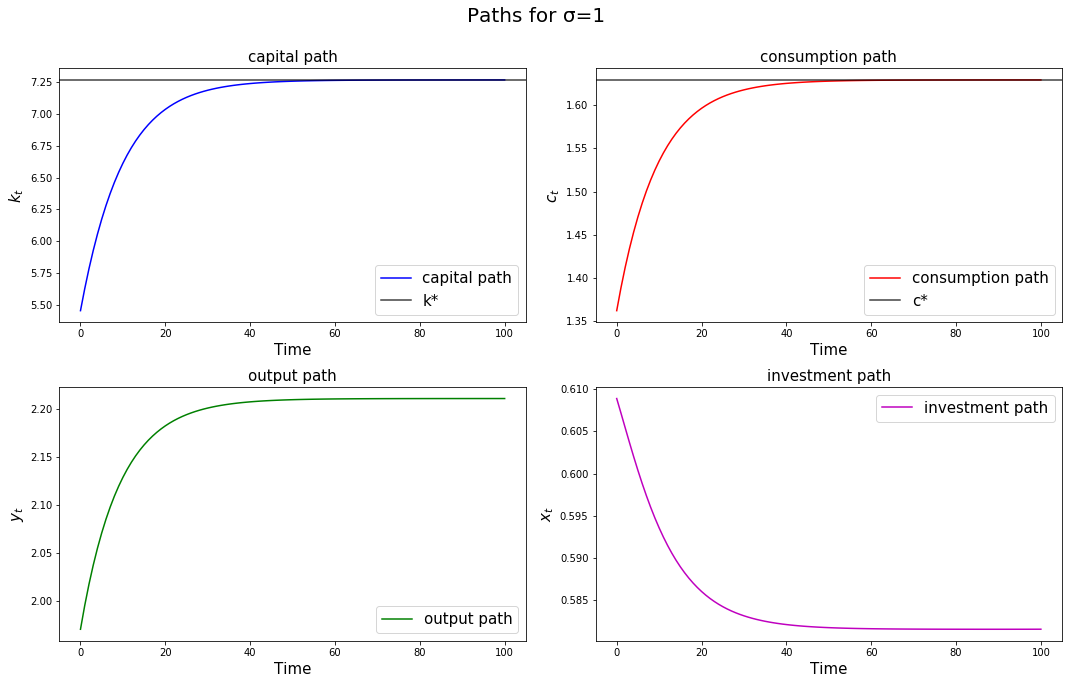

In [8]:
mod = Model(σ=1)

start = timer()

k0 = mod.k_star*0.75
c0_upper = mod.prod_ftion(k0) + (1-mod.δ)*k0
interval = [0, c0_upper]
ϵ=1e-5

for i in range(100):
    
    c = (interval[0]+interval[1])/2

    diff_k, diff_c = planning_problem(mod, c)

    if diff_k<0:
        interval = [c, interval[1]]
    elif diff_k>0 or str(diff_k)=='nan':
        interval = [interval[0], c]
    else:
        print('error', c, diff_k, diff_c)
    
    if abs(diff_k)<ϵ:
        print(f'loop stopped at iternation {i}\n')
        break    
        
diff_k, diff_c = planning_problem(mod, c0=c, verbose=True)

end = timer()
print('elapsed time: ', end-start)

plot_results(mod)
mod1 = mod

## $\sigma=2$

loop stopped at iternation 35

=============== STEADY STATES ===============
steady state of capital is 7.269
steady state of consumption is 1.629


=============== CONVERGENCE ===============
convergence of capital: True (-4.1145019000765615e-06)
convergence of consumption: False (0.0003341594021886163)
final c0:  1.4187352426628466


elapsed time:  0.01706807452522696


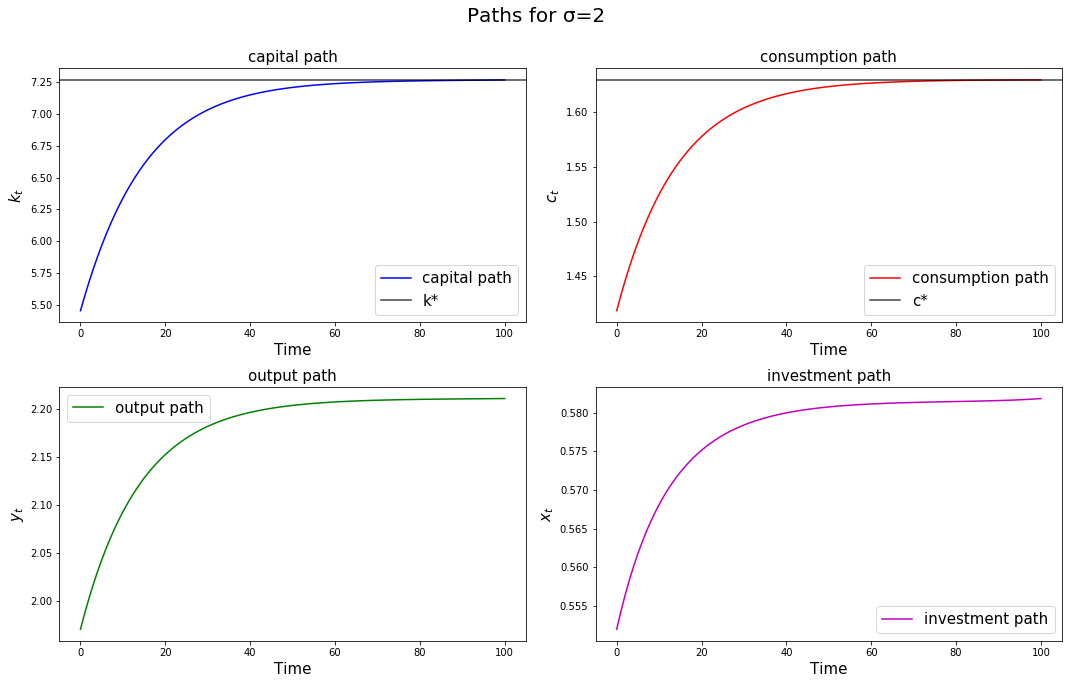

In [9]:
mod = Model(σ=2)

start = timer()

k0 = mod.k_star*0.75
c0_upper = mod.prod_ftion(k0) + (1-mod.δ)*k0
interval = [0, c0_upper]
ϵ=1e-5

for i in range(50):
    
    c = (interval[0]+interval[1])/2

    diff_k, diff_c = planning_problem(mod, c)

    if diff_k<0:
        interval = [c, interval[1]]
    elif diff_k>0 or str(diff_k)=='nan':
        interval = [interval[0], c]
    else:
        print('error', c, diff_k, diff_c)
    
    if abs(diff_k)<ϵ:
        print(f'loop stopped at iternation {i}\n')
        break    
        
diff_k, diff_c = planning_problem(mod, c0=c, verbose=True)

end = timer()
print('elapsed time: ', end-start)

plot_results(mod)
mod2 = mod

## Comparison

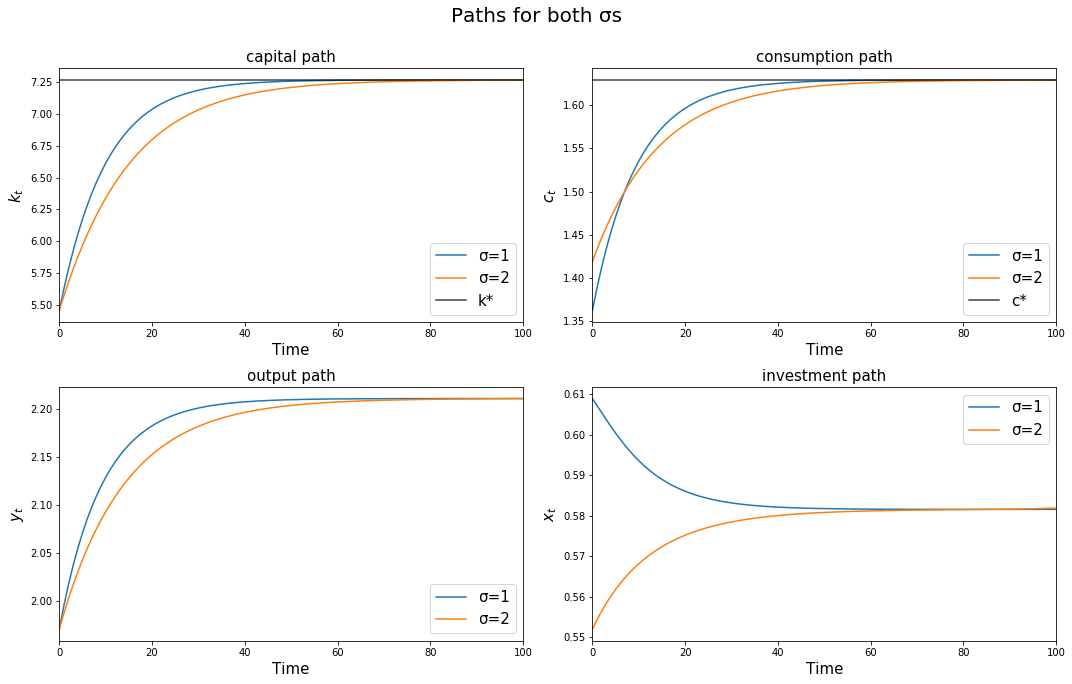

In [6]:
# PREPARING DATA
T=100
time = np.linspace(0, T, T+1)

df = pd.DataFrame(index=time)

df['cap_1'], df['cap_2'] = mod1.paths[0], mod2.paths[0]
df['cons_1'], df['cons_2'] = mod1.paths[1], mod2.paths[1]
df['out_1'], df['out_2'] = mod1.paths[2], mod2.paths[2]
df['inv_1'], df['inv_2'] = mod1.paths[3], mod2.paths[3]

colnames = [['cap_1', 'cap_2'], ['cons_1', 'cons_2'], ['out_1', 'out_2'], ['inv_1', 'inv_2']]

# PLOT IT!!!
fig, (ax12, ax34) = plt.subplots(2,2, figsize=(15,9))
axes = np.append(ax12, ax34)

labels = ['capital path', 'consumption path', 'output path', 'investment path']
ylabels = ['$k_t$', '$c_t$', '$y_t$', '$x_t$']
time = np.linspace(0, T, T+1)

fig.suptitle(f'Paths for both σs', fontsize=20, y=1.05)

for i, ax in enumerate(axes):

    df_help = df[colnames[i]]
    df_help.columns=['σ=1', 'σ=2']
    df_help.plot(ax=ax)
    
    if i==0:
        ax.axhline(y=mod1.k_star, alpha=0.75, label='k*', color = 'black')
    elif i==1:
        ax.axhline(y=mod1.c_star, alpha=0.75, label='c*', color = 'black')

    ax.set_xlabel('Time', fontsize=15)
    ax.set_ylabel(ylabels[i], fontsize=15)
    ax.set_title(labels[i], fontsize=15)
    ax.legend(fontsize=15)

plt.tight_layout()
plt.show() 